### Linear regression performance over 20 trials
The advisor updates via linear regression and samples (chooses) a configuration via softmax.

In [1]:
import json
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
from math import sqrt
from tqdm import tqdm
from copy import deepcopy
from common import set_matplotlib_latex, plot_colours, Advisor, set_axes_length, Landscape
set_matplotlib_latex()
plot_width = 1.05
plot_height = 0.7

def mean_std_linear_regression_rewards(landscapes, nr_trials):
    # returns the mean rewards and standard deviations of the rewards
    # by following linear regression
    rounds_rewards = []
    for landscape in tqdm(landscapes):
        all_combinations = landscape.get_combinations()
        advisor = Advisor(landscape.get_block_nr1(), landscape.get_block_nr2())
        round_rewards = []
        for _ in range(nr_trials):
            selected_combination = advisor.sample_combination(all_combinations)
            selection = landscape.selection_with_noisy_reward(selected_combination)
            advisor.update_with_selection(selection)
            reward = selection.get_reward_in_percentage(landscape.get_min_reward(), landscape.get_max_reward())
            round_rewards.append(reward)
        rounds_rewards.append(round_rewards)
    return np.mean(rounds_rewards, axis=0), np.std(rounds_rewards, axis=0)


def load_landscape_trios():
    with open(f"../landscapes/landscape_trios_20.json", "r", encoding="utf-8") as file:
        landscape_trios_json = json.load(file)
    landscapes = []
    for trio_json in landscape_trios_json:
        for landscape_json in trio_json:
            landscape = Landscape(landscape_json["coefficients_low"], landscape_json["coefficients_high"],
                                  landscape_json["block_nr1"], landscape_json["block_nr2"], 0)
            landscapes.append(landscape)
    return landscapes

def plot_mean_rewards_confidence_interval(rewards_mean, rewards_std):
    trial_numbers = list(range(1, 21))
    plt.plot(trial_numbers, rewards_mean, color=plot_colours["ai"])
    plt.fill_between(trial_numbers, rewards_mean - 1.96 * rewards_std / sqrt(len(rewards_mean)),
                     rewards_mean + 1.96 * rewards_std / sqrt(len(rewards_mean)), color=plot_colours["ai"], alpha=0.2, linewidth=0.0)
    plt.xlim(1, 20)
    plt.xlabel("Trial", labelpad=8, verticalalignment="center")
    plt.ylabel("Reward (\%)", loc='top')
    plt.gca().yaxis.set_major_locator(MultipleLocator(10))
    set_axes_length(plot_width, plot_height)
    plt.savefig("../figures/linear_regression_performance/linear_regression.pdf", bbox_inches='tight')
    plt.show()

100%|██████████| 6000/6000 [20:27<00:00,  4.89it/s]


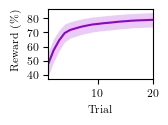

In [11]:
repeat_landscape = 100
nr_trials = 20

landscapes = load_landscape_trios()
results_json = []
all_landscapes = []
for landscape in landscapes:
    for _ in range(repeat_landscape):
        landscape_copy = deepcopy(landscape)
        landscape_copy.init_scaled_rewards()
        all_landscapes.append(landscape_copy)
rewards_mean, rewards_std = mean_std_linear_regression_rewards(all_landscapes, nr_trials)
plot_mean_rewards_confidence_interval(rewards_mean, rewards_std)
results_json.append({"rewards_mean": list(rewards_mean), "rewards_std": list(rewards_std)})

with open(f"../outputs/linear_regression_performance/linear_regression.json", "w",
        encoding="utf-8") as file:
    json.dump(results_json, file, ensure_ascii=False, indent=4)